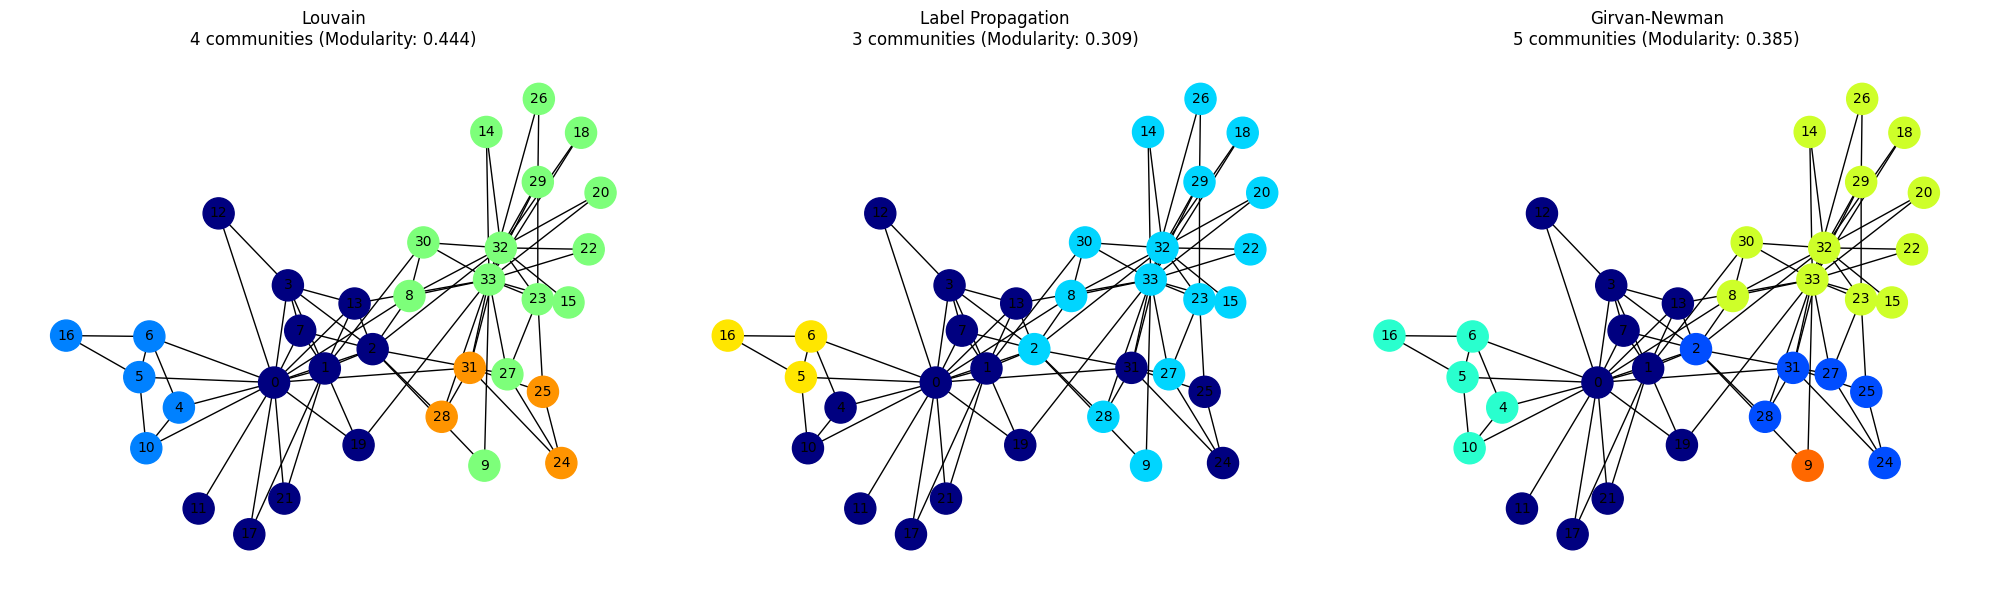

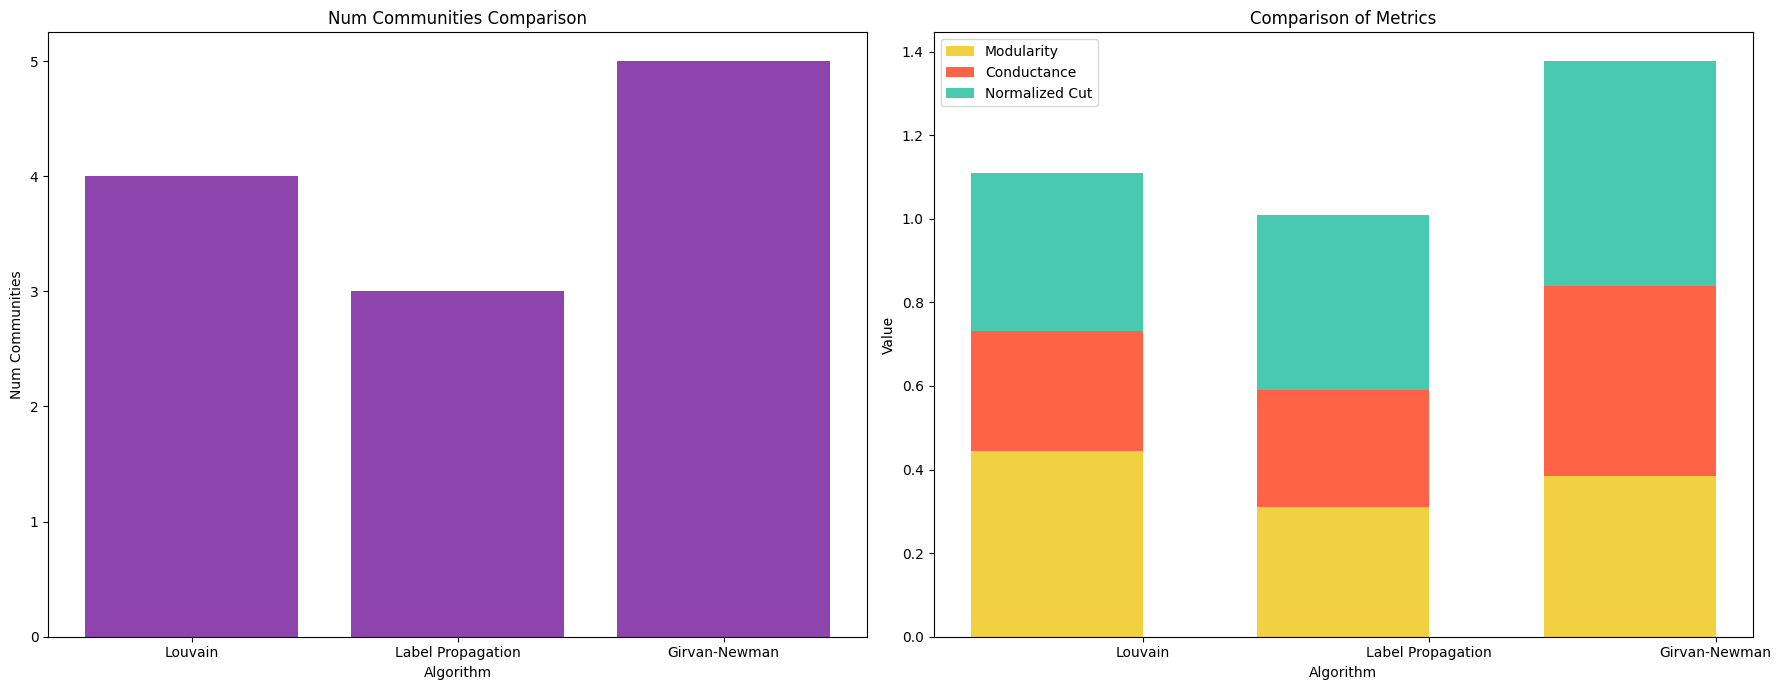

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms import community, cuts
from typing import List, Dict, Any
from abc import ABC, abstractmethod

class CommunityDetector(ABC):
    """Abstract base class for community detection algorithms"""
    
    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.communities = None
        
    @abstractmethod
    def detect_communities(self) -> List[set]:
        """Implement specific community detection algorithm"""
        pass
    
    def get_metrics(self) -> Dict[str, float]:
        """Calculate evaluation metrics for detected communities"""
        if self.communities is None:
            raise ValueError("Communities not detected yet. Run detect_communities() first.")
            
        return {
            'num_communities': len(self.communities),
            'modularity': community.modularity(self.graph, self.communities),
            'conductance': np.mean([cuts.conductance(self.graph, c) for c in self.communities]),
            'normalized_cut': np.mean([cuts.normalized_cut_size(self.graph, c) for c in self.communities])
        }

class LouvainDetector(CommunityDetector):
    def detect_communities(self) -> List[set]:
        self.communities = list(community.louvain_communities(self.graph))
        return self.communities

class LabelPropagationDetector(CommunityDetector):
    def detect_communities(self) -> List[set]:
        self.communities = list(community.label_propagation_communities(self.graph))
        return self.communities

class GirvanNewmanDetector(CommunityDetector):
    def detect_communities(self) -> List[set]:
        generator = community.girvan_newman(self.graph)
        self.communities = max(generator, key=lambda partition: community.modularity(self.graph, partition))
        return self.communities

class CommunityVisualizer:
    """Class for visualizing community detection results"""
    
    @staticmethod
    def create_community_node_colors(graph: nx.Graph, communities: List[set]) -> List[Any]:
        node_colors = []
        for node in graph:
            for idx, comm in enumerate(communities):
                if node in comm:
                    node_colors.append(plt.cm.jet(idx / len(communities)))
                    break
        return node_colors
    
    @staticmethod
    def plot_communities(graph: nx.Graph, communities: List[set], title: str, ax: plt.Axes) -> None:
        node_colors = CommunityVisualizer.create_community_node_colors(graph, communities)
        pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
        modularity = community.modularity(graph, communities)
        
        ax.set_title(f"{title}\n{len(communities)} communities (Modularity: {modularity:.3f})")
        nx.draw(graph, pos=pos, node_size=500, node_color=node_colors,
                with_labels=True, font_size=10, ax=ax)

class CommunityAnalysisPipeline:
    """Pipeline for community detection and analysis"""
    
    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.detectors = {
            'Louvain': LouvainDetector(graph),
            'Label Propagation': LabelPropagationDetector(graph),
            'Girvan-Newman': GirvanNewmanDetector(graph)
        }
        self.results = {}
        
    def run_analysis(self) -> None:
        """Run all community detection algorithms and collect results"""
        for name, detector in self.detectors.items():
            communities = detector.detect_communities()
            metrics = detector.get_metrics()
            self.results[name] = {
                'communities': communities,
                'metrics': metrics
            }
    
    def visualize_results(self) -> None:
        """Create visualization of all community detection results"""
        fig, axes = plt.subplots(1, len(self.detectors), figsize=(20, 6))
        
        for idx, (name, result) in enumerate(self.results.items()):
            CommunityVisualizer.plot_communities(
                self.graph, 
                result['communities'],
                name,
                axes[idx]
            )
        
        plt.tight_layout()
        plt.show()
        
    def compare_metrics(self) -> None:
        """Create comparison plots of metrics"""
        metrics_data = []
        for name, result in self.results.items():
            metrics = result['metrics']
            metrics['Algorithm'] = name
            metrics_data.append(metrics)
            
        metrics_df = pd.DataFrame(metrics_data)
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        
        # Number of communities comparison
        axes[0].bar(metrics_df['Algorithm'], metrics_df['num_communities'], color="#8E44AD")
        axes[0].set_title("Num Communities Comparison")
        axes[0].set_xlabel("Algorithm")
        axes[0].set_ylabel("Num Communities")
        
        # Other metrics comparison
        bar_width = 0.6
        x = np.arange(len(metrics_df['Algorithm']))
        
        axes[1].bar(x - bar_width/2, metrics_df['modularity'], width=bar_width, 
                   label='Modularity', color="#F2D140")
        axes[1].bar(x - bar_width/2, metrics_df['conductance'], width=bar_width,
                   label='Conductance', color="#FF6347", bottom=metrics_df['modularity'])
        axes[1].bar(x - bar_width/2, metrics_df['normalized_cut'], width=bar_width,
                   label='Normalized Cut', color="#48C9B0", 
                   bottom=metrics_df['modularity'] + metrics_df['conductance'])
        
        axes[1].set_title("Comparison of Metrics")
        axes[1].set_xlabel("Algorithm")
        axes[1].set_ylabel("Value")
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(metrics_df['Algorithm'])
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load example graph
    G = nx.karate_club_graph()
    
    # Create and run pipeline
    pipeline = CommunityAnalysisPipeline(G)
    pipeline.run_analysis()
    
    # Visualize results
    pipeline.visualize_results()
    pipeline.compare_metrics()


# **2. Thuật toán Louvain để phát hiện cộng đồng**

## **Tổng quan về thuật toán Louvain**

**Louvain** là một thuật toán phát hiện cộng đồng hiệu quả, thường được sử dụng để phân cụm các đỉnh trong đồ thị nhằm xác định các cộng đồng. Thuật toán được đề xuất bởi **Vincent D. Blondel** và cộng sự vào năm 2008.

### **Nguyên lý hoạt động**

Thuật toán Louvain dựa trên **tối ưu hóa độ modularity** (chỉ số đánh giá chất lượng cộng đồng), hoạt động theo hai giai đoạn lặp đi lặp lại:

1. **Giai đoạn 1: Gán nhãn cộng đồng cục bộ**

   - Mỗi đỉnh được gán vào một cộng đồng khác nhau.
   - Tối ưu hóa độ modularity cục bộ: Đỉnh \( i \) sẽ chuyển vào cộng đồng \( C \) của đỉnh láng giềng nếu điều này làm tăng giá trị **modularity**.

2. **Giai đoạn 2: Gom cụm cộng đồng**
   - Các cộng đồng được gom lại thành các "siêu đỉnh" (super-nodes).
   - Xây dựng một đồ thị mới, trong đó:
     - Mỗi cộng đồng là một siêu đỉnh.
     - Trọng số các cạnh giữa siêu đỉnh là tổng trọng số các cạnh giữa các đỉnh trong cộng đồng gốc.

Quá trình này lặp lại cho đến khi độ modularity hội tụ hoặc không thể cải thiện được nữa.

---

### **Độ Modularity**

Độ modularity \( Q \) đo lường chất lượng của việc chia đồ thị thành các cộng đồng. Công thức tính modularity là:
\[
Q = \frac{1}{2m} \sum*{i,j} \left[ A*{ij} - \frac{k_i k_j}{2m} \right] \delta(C_i, C_j)
\]

Trong đó:

- \( A\_{ij} \): Trọng số của cạnh giữa đỉnh \( i \) và \( j \),
- \( k_i \): Tổng trọng số của các cạnh nối với đỉnh \( i \),
- \( m \): Tổng trọng số của tất cả các cạnh trong đồ thị,
- \( \delta(C_i, C_j) \): Hàm chỉ thị, bằng 1 nếu \( i \) và \( j \) thuộc cùng một cộng đồng, ngược lại bằng 0.

**Mục tiêu**: Tối ưu hóa \( Q \) để đạt giá trị cao nhất có thể.

---

### **Độ phức tạp của thuật toán Louvain**

- **Độ phức tạp**: \( O(n \log n) \) với \( n \) là số đỉnh trong đồ thị.
- Thuật toán này có thể mở rộng hiệu quả với đồ thị lớn, cả đồ thị có trọng số và không có trọng số.

---

## **3. Các chỉ số đánh giá việc phát hiện cộng đồng**

### **3.1. Modularity**

**Mục tiêu**: Đo lường mức độ "chặt chẽ" của các cộng đồng trong đồ thị.

**Công thức**:
\[
Q = \frac{1}{2m} \sum*{i,j} \left[ A*{ij} - \frac{k_i k_j}{2m} \right] \delta(C_i, C_j)
\]

- \( Q \) nằm trong khoảng \([-0.5, 1]\),
- **Q > 0.3**: Phát hiện cộng đồng tốt.

---

### **3.2. NMI (Normalized Mutual Information)**

**Mục tiêu**: So sánh hai kết quả phân cụm dựa trên lý thuyết thông tin.

**Công thức**:
\[
\text{NMI} = \frac{2 \cdot I(X, Y)}{H(X) + H(Y)}
\]
Trong đó:

- \( I(X, Y) \): Thông tin tương hỗ giữa hai phân cụm \( X \) và \( Y \),
- \( H(X), H(Y) \): Entropy của phân cụm \( X \) và \( Y \).

**Phạm vi**: \( [0, 1] \)

- \( 1 \): Phân cụm hoàn hảo.
- \( 0 \): Phân cụm hoàn toàn khác biệt.

---

### **3.3. Rand Index**

**Mục tiêu**: Đo lường sự tương đồng giữa hai kết quả phân cụm.

**Công thức**:
\[
\text{RI} = \frac{a + b}{a + b + c + d}
\]
Trong đó:

- \( a \): Số cặp điểm cùng cộng đồng trong cả hai kết quả,
- \( b \): Số cặp điểm khác cộng đồng trong cả hai kết quả,
- \( c \): Số cặp điểm cùng cộng đồng trong một kết quả, khác cộng đồng ở kết quả còn lại,
- \( d \): Số cặp điểm khác cộng đồng trong một kết quả, cùng cộng đồng ở kết quả còn lại.

**Phạm vi**: \( [0, 1] \)

- **Gần 1**: Phân cụm tốt.

---

### **3.4. Silhouette Score**

**Mục tiêu**: Đo lường sự chặt chẽ bên trong cộng đồng và khoảng cách giữa các cộng đồng.

**Công thức**:
\[
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
\]
Trong đó:

- \( a(i) \): Khoảng cách trung bình giữa đỉnh \( i \) và các đỉnh trong cùng cộng đồng.
- \( b(i) \): Khoảng cách trung bình giữa đỉnh \( i \) và các đỉnh trong cộng đồng gần nhất khác.

**Phạm vi**: \( [-1, 1] \)

- \( s(i) \) gần 1: Đỉnh nằm trong cộng đồng đúng đắn.
- \( s(i) \) gần -1: Đỉnh nằm sai cộng đồng.

---

### **3.5. Coverage**

**Mục tiêu**: Tỷ lệ các cạnh nằm trong cộng đồng so với tổng số cạnh.

**Công thức**:
\[
\text{Coverage} = \frac{\text{Số cạnh trong cộng đồng}}{\text{Tổng số cạnh trong đồ thị}}
\]

**Phạm vi**: \( [0, 1] \)

- \( 1 \): Tất cả các cạnh đều nằm trong cộng đồng.
- **Giá trị cao** cho thấy cộng đồng được chia hợp lý.

---

### **Tổng kết bảng so sánh các chỉ số**

| **Chỉ số**           | **Phạm vi**   | **Ý nghĩa**                                    | **Đánh giá tốt**            |
| -------------------- | ------------- | ---------------------------------------------- | --------------------------- |
| **Modularity**       | \([-0.5, 1]\) | Độ chặt chẽ của cộng đồng                      | \( Q > 0.3 \)               |
| **NMI**              | \([0, 1]\)    | Độ tương đồng giữa hai phân cụm                | \( \text{NMI} \to 1 \)      |
| **Rand Index**       | \([0, 1]\)    | So sánh sự tương đồng của hai kết quả phân cụm | \( \text{RI} \to 1 \)       |
| **Silhouette Score** | \([-1, 1]\)   | Sự chặt chẽ của cộng đồng                      | \( s(i) > 0.5 \)            |
| **Coverage**         | \([0, 1]\)    | Tỷ lệ cạnh trong cộng đồng                     | \( \text{Coverage} \to 1 \) |

---

## **Kết luận**

- **Louvain** là một thuật toán tối ưu hóa modularity hiệu quả và có độ phức tạp thấp.
- Các chỉ số như **Modularity**, **NMI**, **Rand Index**, và **Silhouette Score** là các tiêu chuẩn quan trọng để đánh giá chất lượng phát hiện cộng đồng.


In [4]:
# First cell - Install required package
!pip install python-louvain

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9387 sha256=f64c32053f5b8d3d2892e3d5ec2c16942e8396d9a3c98315aaddc1b6111f64e0
  Stored in directory: /Users/KhangDS/Library/Caches/pip/wheels/ee/52/54/7ecd0f1ebf5f5a8466f70a27ed2b94d20b955376879d6159c5
Successfully built python-louvain

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms import community, cuts 
from community import community_louvain  # for older versions

import seaborn as sns

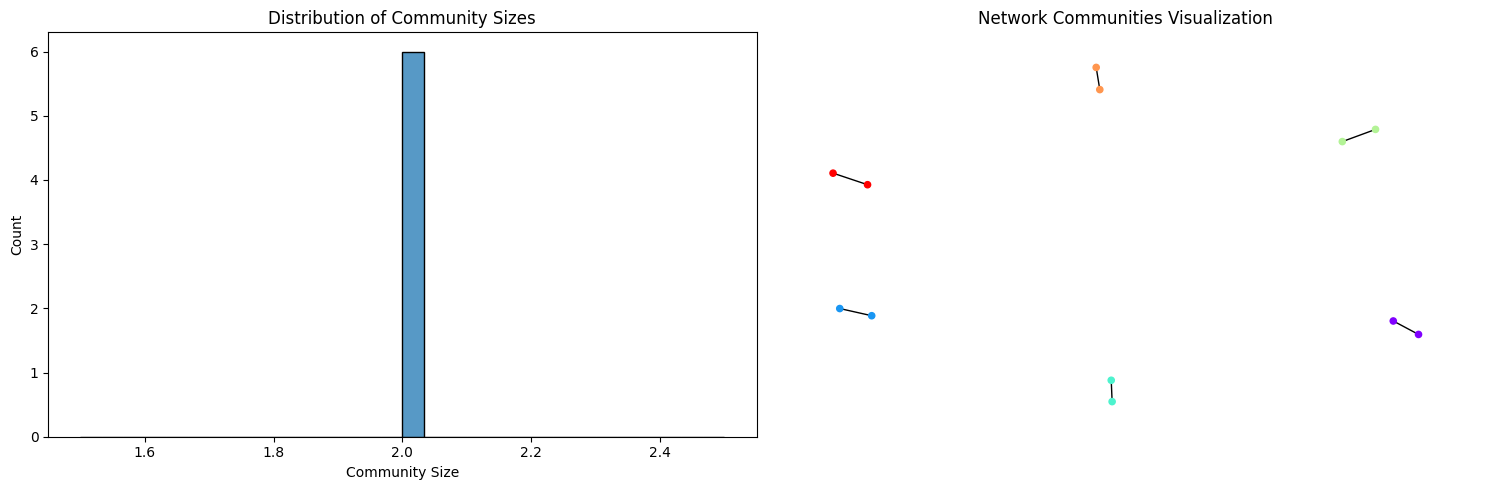


Basic Network Statistics:
Nodes: 12.00
Edges: 6.00
Average Degree: 1.00
Number of Communities: 6.00

Community Detection Metrics:
Modularity: 0.83
Average Community Size: 2.00
Max Community Size: 2.00
Min Community Size: 2.00


In [11]:
# 3. Phân tích cộng đồng trên mạng xã hội Facebook
# Load Facebook network data
# Đây là dataset về mạng kết bạn Facebook từ SNAP (Stanford Network Analysis Project)
G = nx.read_edgelist("/Users/Shared/DATA/Social_Network/demo_codes/input_data/us_edgelist.csv")

class CommunityAnalyzer:
    def __init__(self, G):
        self.G = G
        self.communities = None
        
    def detect_communities(self):
        self.communities = community_louvain.best_partition(self.G)
        return self.communities
    
    def get_basic_stats(self):
        return {
            'Nodes': self.G.number_of_nodes(),
            'Edges': self.G.number_of_edges(),
            'Average Degree': np.mean([d for n, d in self.G.degree()]),
            'Number of Communities': len(set(self.communities.values()))
        }
    
    def analyze_communities(self):
        community_sizes = pd.Series(self.communities).value_counts()
        
        metrics = {
            'Modularity': community.modularity(self.G, 
                [set(n for n, c in self.communities.items() if c == i) 
                 for i in range(max(self.communities.values()) + 1)]),
            'Average Community Size': community_sizes.mean(),
            'Max Community Size': community_sizes.max(),
            'Min Community Size': community_sizes.min()
        }
        
        return metrics, community_sizes

# Analyze Facebook network
analyzer = CommunityAnalyzer(G)
communities = analyzer.detect_communities()
basic_stats = analyzer.get_basic_stats()
metrics, community_sizes = analyzer.analyze_communities()

# Visualization of results
plt.figure(figsize=(15, 5))

# Plot 1: Community Size Distribution
plt.subplot(121)
sns.histplot(community_sizes, bins=30)
plt.title('Distribution of Community Sizes')
plt.xlabel('Community Size')
plt.ylabel('Count')

# Plot 2: Network with Communities
plt.subplot(122)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=list(communities.values()), 
        cmap=plt.cm.rainbow, node_size=20)
plt.title('Network Communities Visualization')

plt.tight_layout()
plt.show()

# Print analysis results
print("\nBasic Network Statistics:")
for k, v in basic_stats.items():
    print(f"{k}: {v:.2f}")

print("\nCommunity Detection Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")